# **SETUP**

In [2]:
from os import path
from google.colab import files
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print(accelerator)

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda:0")

cu80
0.4.1
True


In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# f1 = drive.CreateFile({'id': '1cFyVZjK-T9b02H2-vpX_GuhTklqojKsa'})
# f1.GetContentFile('test_vectors.npy')
# print("Loaded test vectors")

# f1 = drive.CreateFile({'id': '1G6OhSk4aEHcFiQuobI9TIXfTNvJqiiMo'})
# f1.GetContentFile('train_vectors.npy')
# print("Loaded train vectors")

# f1 = drive.CreateFile({'id': '1KYx5JouFMbrIWbwyGaP1SHlGAT-uePOT'})
# f1.GetContentFile('test_sentences.npy')

# f1 = drive.CreateFile({'id': '134nqEfHiMDeUQquQCy5nokJmBFSwm-yc'})
# f1.GetContentFile('train_sentences.npy')

# f1 = drive.CreateFile({'id': '1ID2of27IM6halEUCQekl6RrpBRdComI-'})
# f1.GetContentFile('model1.tar')
# print("Loaded model1")

# f1 = drive.CreateFile({'id': '11_z3Kc4vNLPbHmeuF3H_9c9ewo0r0x2C'})
# f1.GetContentFile('model2.tar')
# print("Loaded model2")

# f1 = drive.CreateFile({'id': '192ZJf8L0C-BlZJUNIRC9ELjrFCTbeJHk'})
# f1.GetContentFile('model3.tar')
# print("Loaded model3")

# f1 = drive.CreateFile({'id': '1zNjRPk7EUB7xxelSjax2mCAhQJBfeHYQ'})
# f1.GetContentFile('model4.tar')
# print("Loaded model4")

all_files = [(name, os.path.getmtime(name)) for name in os.listdir()]
print(all_files)
 

[('.config', 1544221350.396336), ('test_vectors.npy', 1544224600.2521), ('train_vectors.npy', 1544224632.2050755), ('model4.tar', 1544224684.863036), ('adc.json', 1544221350.432336), ('model1.tar', 1544224642.2520678), ('train_sentences.npy', 1544224634.2610738), ('model2.tar', 1544224656.7650568), ('model3.tar', 1544224671.0270462), ('test_sentences.npy', 1544224633.4190745), ('sample_data', 1544031593.0)]


In [0]:
import torch
import torch.nn as nn
import time
from torch.autograd import Variable
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import seaborn as sns

experiment = "seperate_models"

train_vectors = np.load("train_vectors.npy")
train_sentences = np.load("train_sentences.npy")

vec = train_vectors[::5], train_vectors[1::5], train_vectors[2::5], train_vectors[3::5], train_vectors[4::5]
sen = train_sentences[::5], train_sentences[1::5], train_sentences[2::5], train_sentences[3::5], train_sentences[4::5]

dataset1 = np.asarray(vec[0:2])
dataset2 = np.asarray(vec[0:3])
dataset3 = np.asarray(vec[0:4])
dataset4 = np.asarray(vec[0:5])


sentences1 = np.asarray(sen[0:2])
sentences2 = np.asarray(sen[0:3])
sentences3 = np.asarray(sen[0:4])
sentences4 = np.asarray(sen[0:5])



test_vectors = np.load("test_vectors.npy")
test_sentences = np.load("test_sentences.npy")


vec = test_vectors[::5], test_vectors[1::5], test_vectors[2::5], test_vectors[3::5], test_vectors[4::5]
sen = test_sentences[::5], test_sentences[1::5], test_sentences[2::5], test_sentences[3::5], test_sentences[4::5]

test_dataset1 = np.asarray(vec[0:2])
test_dataset2 = np.asarray(vec[0:3])
test_dataset3 = np.asarray(vec[0:4])
test_dataset4 = np.asarray(vec[0:5])

vec = None

test_sentences1 = np.asarray(sen[0:2])
test_sentences2 = np.asarray(sen[0:3])
test_sentences3 = np.asarray(sen[0:4])
test_sentences4 = np.asarray(sen[0:5])

sen = None


In [0]:
class BasicGRU(nn.Module):
    def __init__(self, hidden_size, n_layers=1):
        super(BasicGRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=0, bidirectional=True)       
        self.lin = nn.Linear(hidden_size, hidden_size)

    def forward(self, input_seq, input_lengths, hidden=None):

        packed = torch.nn.utils.rnn.pack_padded_sequence(input_seq, input_lengths, batch_first=True)

        outputs, hidden = self.gru(packed, hidden)
        
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs , batch_first=True)

        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]

        output = self.lin(outputs[:,-1,:].unsqueeze(1))
        return output

In [0]:
class StoryVectors(Dataset):

    def __init__(self, dataset, sentences):
        self.dataset = dataset
        self.type = self.dataset.shape[0]
        self.sen = sentences

        

    def __len__(self):
        return self.dataset.shape[1]

    def __getitem__(self, idx):
      
        if self.type == 2:
            X = [self.dataset[0][idx]]
            y = [self.dataset[1][idx]]
            sentences = [self.sen[0][idx], self.sen[1][idx]]
          
          
        elif self.type == 3:
            X = [self.dataset[0][idx], self.dataset[1][idx]]
            y = [self.dataset[2][idx]]
            sentences = [self.sen[0][idx], self.sen[1][idx], self.sen[2][idx]]
        
        elif self.type == 4:
            X = [self.dataset[0][idx], self.dataset[1][idx], self.dataset[2][idx]]
            y = [self.dataset[3][idx]]
            sentences = [self.sen[0][idx], self.sen[1][idx], self.sen[2][idx], self.sen[3][idx]]
        
        elif self.type == 5:
            X = [self.dataset[0][idx], self.dataset[1][idx], self.dataset[2][idx], self.dataset[3][idx]]
            y = [self.dataset[4][idx]]
            sentences = [self.sen[0][idx], self.sen[1][idx], self.sen[2][idx], self.sen[3][idx], self.sen[4][idx]]
        
        
        return [X, len(X), y, sentences]
      
def vocab_collate_func(batch):
    X = []
    y = []
    lengths = []
    sentences = []

    for datum in batch:
        X.append(datum[0])
        lengths.append(datum[1])
        y.append(datum[2])
        sentences.append(datum[3])

    return [torch.FloatTensor(X), torch.LongTensor(lengths), torch.FloatTensor(y), sentences]

In [0]:
model1 = torch.load("model1.tar")
model2 = torch.load("model2.tar")
model3 = torch.load("model3.tar")
model4 = torch.load("model4.tar")

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
def distr(array):
    plt.scatter([i for i in range(len(array))], sorted(array))
    plt.savefig('1.pdf')
    plt.show()

def nn(qvec, vectors, array, k=5):
    qvec /= np.linalg.norm(qvec)
    vectors = np.asarray([ i / np.linalg.norm(i) for i in vectors.tolist()])
    scores = np.dot(qvec, vectors.T).flatten()
    sorted_args = np.argsort(scores)[::-1]
    sentences = [(array[a], scores[a]) for a in sorted_args[:k]]
    for i, s in enumerate(sentences):
        print (s, sorted_args[i])

def analyse(predicted, actual, sentences, mode_vectors, mode_sentences): #mode can be train or test
    
    assert len(predicted) == len(actual), "Check dimensions"
    
    ranks = []
    for p, a, s in zip(predicted, actual, sentences): #iterating through the batch 0-31
        story = sen
        scores = np.dot(p, mode_vectors.T).flatten()
        score_actpred = np.dot(p, a)
        #print("score of act and pred:", score_actpred)
        rank = -1
        sorted_scores = sorted(scores, reverse=True)
        for index, score in enumerate(sorted_scores):
            if np.isclose(score, score_actpred):
                rank = index
                break

        ranks.append(rank)

    return ranks
  
def show_inp_out(actual, predicted, mode_vectors, mode_sentences):
    
    print("Actual Output")
    nn(actual.squeeze().tolist(), mode_vectors, mode_sentences, k=1)

    print("Predicted Output")
    nn(predicted.squeeze().tolist(), mode_vectors, mode_sentences, k=5)

In [9]:

def get_loader(dataset, sentences):
    test_dataset = StoryVectors(dataset, sentences)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=32,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True,
                                           num_workers=4)
    return test_loader
    


def test_model(model, test_loader, test_vectors, test_sentences):
    model.eval()
    ranks = []
    
#     no, sample, dim = test_vectors.shape
#     test_vectors = test_vectors.reshape(no*sample, dim)
#     test_sentences = test_sentences.reshape(no*sample)

    for data, lengths, labels, sentences in test_loader:
        pred = model(data.to(device), lengths.to(device))
        pred = pred.detach().cpu().numpy().squeeze()
        labels = labels.detach().numpy().squeeze()  
        #print(len(pred.tolist()), len(labels.tolist()))
        batch_ranks = analyse(pred.tolist(), labels.tolist(), sentences, test_vectors,  test_sentences)
        ranks.extend(batch_ranks)
    return ranks

test_loader1 = get_loader(test_dataset1, test_sentences1)
test_loader2 = get_loader(test_dataset2, test_sentences2)
test_loader3 = get_loader(test_dataset3, test_sentences3)
test_loader4 = get_loader(test_dataset4, test_sentences4)


print("Evaluating model 1") 
ranks1 = test_model(model1, test_loader1, test_dataset1[-1], test_sentences1[-1]) 

print("Evaluating model 2") 
ranks2 = test_model(model2, test_loader2, test_dataset2[-1], test_sentences2[-1]) 

print("Evaluating model 3") 
ranks3 = test_model(model3, test_loader3, test_dataset3[-1], test_sentences3[-1])

print("Evaluating model 4") 
ranks4 = test_model(model4, test_loader4, test_dataset4[-1], test_sentences4[-1]) 

Evaluating model 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  del sys.path[0]


Evaluating model 2
Evaluating model 3
Evaluating model 4


In [0]:
np.save("ranks1", ranks1)
np.save("ranks2", ranks2)
np.save("ranks3", ranks3)
np.save("ranks4", ranks4)

#files.download("")

In [25]:
all_files = [(name, os.path.getmtime(name)) for name in os.listdir()]
print(all_files)

[('.config', 1544221350.396336), ('test_vectors.npy', 1544224600.2521), ('train_vectors.npy', 1544224632.2050755), ('model4.tar', 1544224684.863036), ('adc.json', 1544221350.432336), ('ranks4.npy', 1544226981.482555), ('ranks1.npy', 1544226981.4805548), ('model1.tar', 1544224642.2520678), ('train_sentences.npy', 1544224634.2610738), ('4.png', 1544227276.9963114), ('model2.tar', 1544224656.7650568), ('model3.tar', 1544224671.0270462), ('ranks2.npy', 1544226981.4815547), ('test_sentences.npy', 1544224633.4190745), ('ranks3.npy', 1544226981.4815547), ('sample_data', 1544031593.0)]


In [0]:
    
def freq(array, name):
  sns.set_style('whitegrid')
  sns_plot = sns.distplot(np.array(array), kde=False, hist=True)
  sns_plot.set(xlabel='Ranks', ylabel='Frequency')
  #sns_plot.
  fig = sns_plot.get_figure()
  fig.savefig(name)
    
   

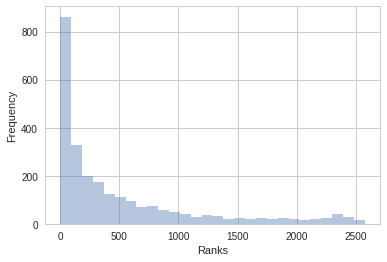

In [57]:
freq(ranks4, "4.pdf")
files.download('4.pdf')

In [0]:
files.download('ranks1.npy')
files.download('ranks2.npy')
files.download('ranks3.npy')
files.download('ranks4.npy')

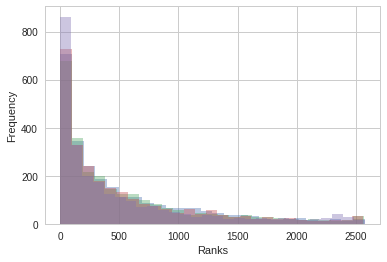

In [53]:
freq(ranks1, "1.pdf")
files.download('1.pdf')

freq(ranks2, "2.pdf")
files.download('2.pdf')

freq(ranks3, "3.pdf")
files.download('3.pdf')

freq(ranks4, "4.pdf")
files.download('4.pdf')

In [60]:
test_dataset1.shape

(2, 2577, 4800)